In [107]:
# these get "Javascript Error: IPython is not defined"
#%matplotlib notebook
#%matplotlib nbagg
%matplotlib inline

In [108]:
import pylab as pl
import numpy as np

### this code snippet will load the next cell with the global preamble

```
with open('preamble.py', 'r') as fh:
    preamble = fh.read()
get_ipython().set_next_input(preamble)
```

In [109]:
#%matplotlib inline
import numpy as np
from astropy import units as u
import pylab as pl
pl.rcParams['figure.figsize'] = (16,8)
import sys
import glob
sys.path.append('/lustre/naasc/users/aginsbur/repos/reduction/reduction/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show
from spectral_cube import SpectralCube
import selfcal_heuristics
import spectral_cube
import os

In [110]:
os.chdir("/lustre/lard/projects/ALMA_IMF/2017.1.01355.L/imaging_results")

In [111]:
import casatools
tb = casatools.table()
msmd = casatools.msmetadata()
ms = casatools.ms()

In [112]:
ls -d ../W51-E_B3*_7M_*/

../W51-E_B3_uid___A001_X1296_X109_continuum_merged_7M_phase1_int.cal//
../W51-E_B3_uid___A001_X1296_X109_continuum_merged_7M_selfcal.ms//


In [138]:
msfile = '../W51-E_B3_uid___A001_X1296_X109_continuum_merged_7M_selfcal.ms/'
caltable = '../W51-E_B3_uid___A001_X1296_X109_continuum_merged_7M_phase1_int.cal/'
tb.open(caltable)

True

In [142]:
tb.open(caltable)
print(tb.colnames())
data = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
spwids = np.unique(data['SPECTRAL_WINDOW_ID'])
fids = np.unique(data['FIELD_ID'])
tb.close()


['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


True

In [141]:
tb.open(msfile+'/ANTENNA')
print(tb.getcol('NAME'))
print(len(tb.getcol('NAME')))
print(tb.colnames())
tb.close()

['CM01' 'CM03' 'CM04' 'CM05' 'CM07' 'CM08' 'CM09' 'CM10' 'CM11' 'CM12'
 'CM06' 'CM02' 'DA42' 'DA43' 'DA44' 'DA45' 'DA46' 'DA47' 'DA48' 'DA49'
 'DA50' 'DA51' 'DA52' 'DA53' 'DA54' 'DA55' 'DA56' 'DA57' 'DA58' 'DA59'
 'DA60' 'DA61' 'DA62' 'DA63' 'DA64' 'DA65' 'DV01' 'DV02' 'DV03' 'DV04'
 'DV05' 'DV06' 'DV07' 'DV08' 'DV09' 'DV11' 'DV12' 'DV14' 'DV15' 'DV16'
 'DV17' 'DV19' 'DV20' 'DV21' 'DV22' 'DV23' 'DV24']
57
['OFFSET', 'POSITION', 'TYPE', 'DISH_DIAMETER', 'FLAG_ROW', 'MOUNT', 'NAME', 'STATION']


True

In [116]:
ms.close()
ms.open(msfile)

True

In [117]:
ms.selectinit(datadescid=9)

True

In [118]:
data = ms.getdata(['antenna1', 'antenna2', 'data', 'corrected_data', 'model_data', 'uvdist'])                

In [119]:
np.any(data['model_data']!=1)

True

In [120]:
data.keys()

dict_keys(['antenna1', 'antenna2', 'corrected_data', 'data', 'model_data', 'uvdist'])

In [121]:
# unique, ordered baselines
baselines = list(set(zip(data['antenna1'], data['antenna2'])))

In [122]:
tb.open(msfile+"/ANTENNA")
positions = tb.getcol('POSITION')
tb.close()
positions.shape
baseline_lengths_m = [((positions[:,ant1]-positions[:,ant2])**2).sum()**0.5 for ant1,ant2 in baselines]
#baseline_lengths_m

In [123]:
datashape = data['corrected_data'].shape
data['corrected_data'].shape, data['antenna1'].shape, data['uvdist'].shape

((2, 10, 15840), (15840,), (15840,))

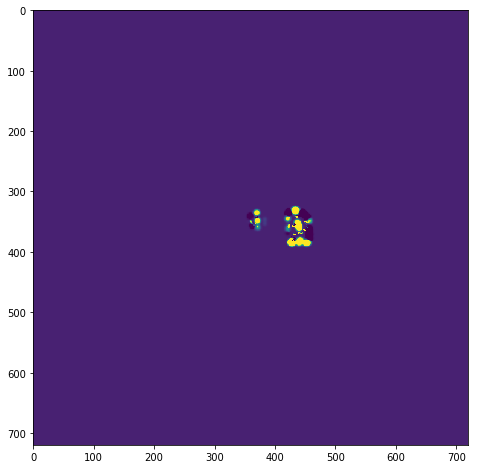

In [124]:
model = SpectralCube.read('W51-E_B3_uid___A001_X1296_X109_continuum_merged_7M_robust0.model.tt0', format='casa_image')
pl.imshow(model[0].value, vmax=0.01, vmin=-0.001)

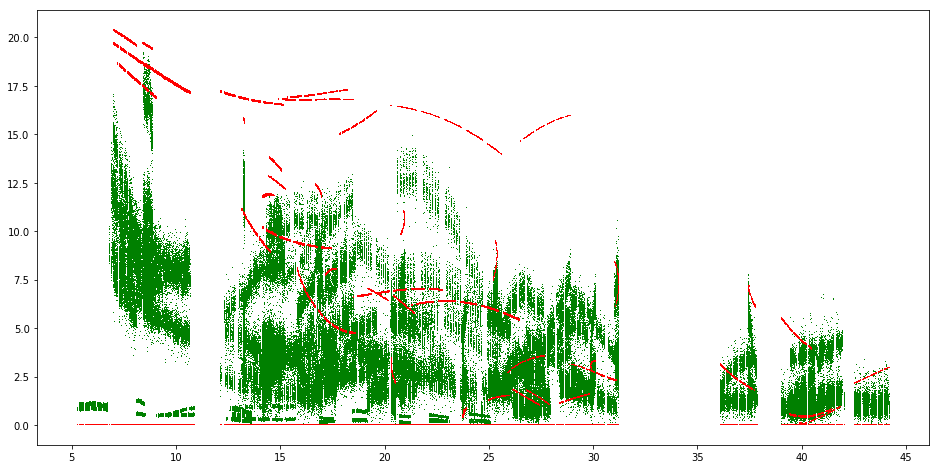

In [125]:
pl.plot(data['uvdist'], np.abs(data['corrected_data'].reshape(datashape[0]*datashape[1], datashape[2]).T), 'g,')
pl.plot(data['uvdist'], np.abs(data['model_data'].reshape(datashape[0]*datashape[1], datashape[2]).T), 'r,')

Preshanth suggested that the only "objective" measure of how well the self-cal is performing is to measure the chi^2 statistic for the model against the pre-calibration and post-calibration data.

In [22]:
for datadescid in spwids:
    ms.open(msfile)
    ms.selectinit(datadescid=datadescid)
    data = ms.getdata(['antenna1', 'antenna2', 'data', 'corrected_data', 'model_data'])
    chi2_corrected = (np.abs(data['corrected_data'] - data['model_data'])**2).sum()/data['data'].size
    chi2_noselfcal = (np.abs(data['data'] - data['model_data'])**2).sum()/data['data'].size
    print(f"SPW {datadescid}: Corrected chi2/n: {chi2_corrected:0.4f}"
          f"  Uncorrected chi2/n: {chi2_noselfcal:0.4f}  Difference selfcal - noselfcal: {chi2_corrected-chi2_noselfcal:0.4f}")

SPW 0: Corrected chi2/n: 20.2334  Uncorrected chi2/n: 20.2334  Difference selfcal - noselfcal: 0.0000
SPW 1: Corrected chi2/n: 21.7181  Uncorrected chi2/n: 21.7181  Difference selfcal - noselfcal: 0.0000
SPW 2: Corrected chi2/n: 16.0862  Uncorrected chi2/n: 16.0862  Difference selfcal - noselfcal: 0.0000
SPW 3: Corrected chi2/n: 14.8560  Uncorrected chi2/n: 14.8560  Difference selfcal - noselfcal: 0.0000
SPW 4: Corrected chi2/n: 22.8251  Uncorrected chi2/n: 22.8251  Difference selfcal - noselfcal: 0.0000
SPW 5: Corrected chi2/n: 23.8335  Uncorrected chi2/n: 23.8335  Difference selfcal - noselfcal: 0.0000
SPW 6: Corrected chi2/n: 16.2813  Uncorrected chi2/n: 16.2813  Difference selfcal - noselfcal: 0.0000
SPW 7: Corrected chi2/n: 11.7204  Uncorrected chi2/n: 11.7204  Difference selfcal - noselfcal: 0.0000
SPW 8: Corrected chi2/n: 21.0236  Uncorrected chi2/n: 21.0236  Difference selfcal - noselfcal: 0.0000
SPW 9: Corrected chi2/n: 23.2382  Uncorrected chi2/n: 23.2382  Difference selfcal 

In [23]:
short_baselines = np.array(list(baselines))[np.array(baseline_lengths) < 1000,:]
long_baselines = np.array(list(baselines))[np.array(baseline_lengths) >= 1000,:]
short_bl_sel = np.zeros(data['antenna1'].shape, dtype='bool')
long_bl_sel = np.zeros(data['antenna1'].shape, dtype='bool')
for ant1,ant2 in short_baselines:
    short_bl_sel[(data['antenna1']==ant1)&(data['antenna2']==ant2)] = True
for ant1,ant2 in long_baselines:
    long_bl_sel[(data['antenna1']==ant1)&(data['antenna2']==ant2)] = True    

NameError: name 'baseline_lengths' is not defined

In [173]:
ms.select?

Signature: ms.select(items={})
Docstring:
This function will select a subset of the current measurement set
based on the range of values for each field in the input record.
The range function will return a record that can be altered and
used as the argument for this function.  A successful selection
returns True. Unrecognized fields are ignored.

Allowable items for select include: 'antenna1', 'antenna2',
'array_id', 'feed1', 'feed2', 'field_id', 'ifr_number', 'rows',
'scan_number', 'data_desc_id', 'time', 'times', 'u', 'v', 'w',
and 'uvdist'.

You need to call selectinit before
calling this function. If you haven't then selectinit will be
called for you with default arguments.

Repeated use of this function, with different arguments, will
further refine the selection, resulting in a successively smaller
selected measurement set. If the selected measurement set does not
contain any rows then this function will return False and send a
warning message in the logger. Otherwise this functi

In [153]:
for datadescid in spwids:
    ms.open(msfile)
    ms.selectinit(datadescid=datadescid)
    data = ms.getdata(['antenna1', 'antenna2', 'data', 'corrected_data', 'model_data'])
    
    short_baselines = np.array(list(baselines))[np.array(baseline_lengths) < 1000,:]
    long_baselines = np.array(list(baselines))[np.array(baseline_lengths) >= 1000,:]
    short_bl_sel = np.zeros(data['antenna1'].shape, dtype='bool')
    long_bl_sel = np.zeros(data['antenna1'].shape, dtype='bool')
    for ant1,ant2 in short_baselines:
        short_bl_sel[(data['antenna1']==ant1)&(data['antenna2']==ant2)] = True
    for ant1,ant2 in long_baselines:
        long_bl_sel[(data['antenna1']==ant1)&(data['antenna2']==ant2)] = True    
    
    print(f"SPW {datadescid}: SHORT Corrected chi2/n: {(np.abs(data['corrected_data'][:,:,short_bl_sel] - data['model_data'][:,:,short_bl_sel])**2).sum()/data['data'][:,:,short_bl_sel].size:0.4f}"
          f"  Unorrected chi2/n: {(np.abs(data['data'][:,:,short_bl_sel] - data['model_data'][:,:,short_bl_sel])**2).sum()/data['data'][:,:,short_bl_sel].size:0.4f}"
          f"  LONG Corrected chi2/n: {(np.abs(data['corrected_data'][:,:,long_bl_sel] - data['model_data'][:,:,long_bl_sel])**2).sum()/data['data'][:,:,long_bl_sel].size:0.4f}"
          f"  Unorrected chi2/n: {(np.abs(data['data'][:,:,long_bl_sel] - data['model_data'][:,:,long_bl_sel])**2).sum()/data['data'][:,:,long_bl_sel].size:0.4f}")


SPW 9: SHORT Corrected chi2/n: 1.1762  Unorrected chi2/n: 1.1782  LONG Corrected chi2/n: 1.0893  Unorrected chi2/n: 1.0845
SPW 10: SHORT Corrected chi2/n: 1.1159  Unorrected chi2/n: 1.1126  LONG Corrected chi2/n: 1.0306  Unorrected chi2/n: 1.0281
SPW 11: SHORT Corrected chi2/n: 1.1852  Unorrected chi2/n: 1.1849  LONG Corrected chi2/n: 1.0980  Unorrected chi2/n: 1.0974
SPW 12: SHORT Corrected chi2/n: 1.2353  Unorrected chi2/n: 1.2345  LONG Corrected chi2/n: 1.1239  Unorrected chi2/n: 1.1209
SPW 13: SHORT Corrected chi2/n: 1.1413  Unorrected chi2/n: 1.1371  LONG Corrected chi2/n: 1.0400  Unorrected chi2/n: 1.0381
SPW 14: SHORT Corrected chi2/n: 1.2248  Unorrected chi2/n: 1.2246  LONG Corrected chi2/n: 1.1442  Unorrected chi2/n: 1.1434
SPW 21: SHORT Corrected chi2/n: 1.2731  Unorrected chi2/n: 1.2743  LONG Corrected chi2/n: 1.1379  Unorrected chi2/n: 1.1369
SPW 22: SHORT Corrected chi2/n: 1.1685  Unorrected chi2/n: 1.1660  LONG Corrected chi2/n: 1.0523  Unorrected chi2/n: 1.0526
SPW 23: S

/lustre/naasc/users/aginsbur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


SPW 33: SHORT Corrected chi2/n: 1.2783  Unorrected chi2/n: 1.2757  LONG Corrected chi2/n: nan  Unorrected chi2/n: nan
SPW 34: SHORT Corrected chi2/n: 1.2741  Unorrected chi2/n: 1.2776  LONG Corrected chi2/n: nan  Unorrected chi2/n: nan
SPW 35: SHORT Corrected chi2/n: 1.2687  Unorrected chi2/n: 1.2742  LONG Corrected chi2/n: nan  Unorrected chi2/n: nan


## TODO

Figure out the ms.select syntax that will get just one field at a time.

In [180]:
ms.open(msfile)
ms.selectinit(datadescid=9)
ms.select({'field_id': fids[0], 'antenna1': baselines[0][0], 'antenna2':baselines[0][1]})
data = ms.getdata(['antenna1', 'antenna2', 'data', 'corrected_data', 'model_data'])
data['data'].shape

(2, 9, 282150)

In [182]:
ms.msselect?

Signature: ms.msselect(items={}, onlyparse=False)
Docstring:
A return value of True implies that the combination of all
selection expressions resulted in a non-Null combined TaQL
expression. False implies that the combined TaQL could not be
formed (i.e. it is Null, and the "selected MS" will be the same as
the input MS).

The details of selection expressions are desribed in the
MSSelection Memo.

Note that this function can be called multiple times but the
result is cumulative.  Each selection will work on the data
already selected from all previous calls of this function.  Use
the function reset() to reset all selections to NULL (original
dataset).
File:      /lustre/naasc/users/aginsbur/anaconda/lib/python3.6/site-packages/casatools/ms.py
Type:      method


In [185]:
chi2s = {}
from astropy.utils.console import ProgressBar
for datadescid in spwids:
    ms.open(msfile)
    chi2s[datadescid] = {}
    for field_id in ProgressBar(fids, ipython_widget=True):
        chi2s[datadescid][field_id] = {}
        for ant1,ant2 in baselines:
            ms.selectinit(datadescid=datadescid)
            ms.select({'field_id': field_id, 'antenna1': ant1, 'antenna2':ant2})
            data = ms.getdata(['antenna1', 'antenna2', 'data', 'corrected_data', 'model_data'])
            ms.reset()

            chi2n_corr = (np.abs(data['corrected_data'] - data['model_data'])**2).sum()/data['data'].size
            chi2n_uncorr = (np.abs(data['data'] - data['model_data'])**2).sum()/data['data'].size

            chi2s[datadescid][field_id][(ant1,ant2)] = (chi2n_corr, chi2n_uncorr)
    break

FloatProgress(value=0.0)

KeyboardInterrupt: 

In [ ]:
for spw in spwids:
    pl.figure()
    pl.suptitle(f"Spectral Window {spw}")
    for field_id in fids:
        pl.subplot(2,1,1).plot(baseline_lengths_m, [chi2s[spw][field_id][key][0] for key in chi2s[spw][field_id]], label=f'{field_id}', marker='o', linestyle='none')
    pl.ylabel("With selfcal chi^2")
    pl.legend(loc='best')
    for field_id in fids:
        pl.subplot(2,1,2).plot(baseline_lengths_m, [chi2s[spw][field_id][key][1] for key in chi2s[spw][field_id]], label=f'{field_id}', marker='o', linestyle='none')
    pl.ylabel("No selfcal chi^2")
    pl.legend(loc='best')
    pl.xlabel("Baseline Length (m)")

In [25]:
okfields,notokfields = selfcal_heuristics.goodenough_field_solutions(caltable,
                                                                     minsnr=5)
print(okfields, notokfields)

[0, 4, 5, 6, 7, 8, 9] []


In [179]:
tb.ncols(), tb.nrows()

(0, 0)

In [143]:
tb.open(caltable)
print(tb.colnames())
data = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
spwids = np.unique(data['SPECTRAL_WINDOW_ID'])
fids = np.unique(data['FIELD_ID'])
tb.close()


['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


True

In [152]:
tb.open(caltable)
print(tb.colnames())
data = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
spwids = np.unique(data['SPECTRAL_WINDOW_ID'])
fids = np.unique(data['FIELD_ID'])
tb.close()


['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


True

In [153]:
tb.colnames()

[]

In [154]:
data['ANGLE'] = np.angle(data['CPARAM']) * 180 / np.pi

In [155]:
fieldOKmask = np.isin(data['FIELD_ID'], okfields)

NameError: name 'okfields' is not defined

In [156]:
fids = np.unique(data['FIELD_ID'])
print(fids)

[1 2 3]


In [157]:
oids = np.unique(data['OBSERVATION_ID'])
print(oids)

[0 1 2 3 4]


In [158]:
spwids = np.unique(data['SPECTRAL_WINDOW_ID'])
print(spwids)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [159]:
# which observations contain which fields?
for oid in oids:
    oid_match = data['OBSERVATION_ID'] == oid
    has_fid = [fid for fid in fids if np.any((data['FIELD_ID'] == fid) & oid_match)]
    print(f"OID {oid} has fields {has_fid}")

OID 0 has fields [1, 2, 3]
OID 1 has fields [1, 2, 3]
OID 2 has fields [1, 2, 3]
OID 3 has fields [1, 2, 3]
OID 4 has fields [1, 2, 3]


In [160]:
fids_12m = np.unique(data['FIELD_ID'])

In [161]:
print({col: data[col].shape for col in data})

{'TIME': (328320,), 'FIELD_ID': (328320,), 'SPECTRAL_WINDOW_ID': (328320,), 'ANTENNA1': (328320,), 'ANTENNA2': (328320,), 'INTERVAL': (328320,), 'SCAN_NUMBER': (328320,), 'OBSERVATION_ID': (328320,), 'CPARAM': (2, 1, 328320), 'PARAMERR': (2, 1, 328320), 'FLAG': (2, 1, 328320), 'SNR': (2, 1, 328320), 'ANGLE': (2, 1, 328320)}


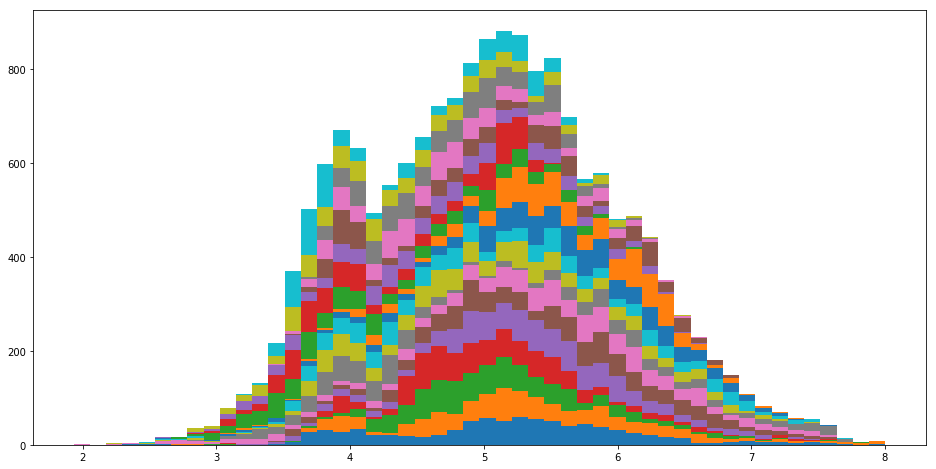

In [162]:
OK = data['SNR'] != 0

toplot = [data['SNR'][0,0, (data['FIELD_ID'] == fids_12m[0]) & (OK[0,0,:]) & (data['SPECTRAL_WINDOW_ID'] == spwid)]
          for spwid in spwids]

H,L,P = pl.hist(toplot, bins=50, stacked=True)

In [163]:
OK = data['SNR'] != 0

toplot = [data['SNR'][0,0, fieldOKmask & (OK[0,0,:]) & (data['ANTENNA1'] == ant)]
          for ant in np.unique(data['ANTENNA1'])]
toplot = [x for x in toplot if len(x) > 0]

_ = pl.boxplot(toplot)

NameError: name 'fieldOKmask' is not defined

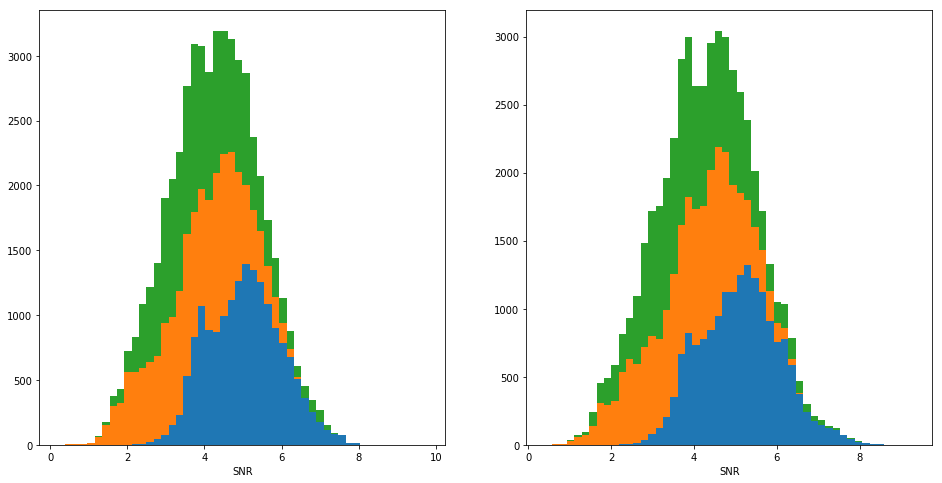

In [174]:
OK = data['SNR'] != 0

toplot = [data['SNR'][0,0, (data['FIELD_ID'] == fid) & (OK[0,0,:])]
          for fid in fids_12m]

pl.subplot(1,2,1)
pl.xlabel("SNR")
H,L,P = pl.hist(toplot, bins=50, stacked=True)

toplot = [data['SNR'][1,0, (data['FIELD_ID'] == fid) & (OK[0,0,:])]
          for fid in fids_12m]

pl.subplot(1,2,2)
pl.xlabel("SNR")
H,L,P = pl.hist(toplot, bins=50, stacked=True)


Per-field stats:

In [168]:
for fid in fids_12m:
    dat = data['SNR'][1,0, (data['FIELD_ID'] == fid) & (OK[0,0,:])]
    ang = data['ANGLE'][1,0, (data['FIELD_ID'] == fid) & (OK[0,0,:])]
    print(f"fid={fid:03d} mean={dat.mean():8.2f} median={np.median(dat):8.2f} std={dat.std():10.2f} angle_rms={ang.std():10.2f}")

fid=001 mean=    5.12 median=    5.14 std=      0.96 angle_rms=     25.38
fid=002 mean=    3.85 median=    3.94 std=      1.08 angle_rms=     30.28
fid=003 mean=    3.99 median=    3.91 std=      1.08 angle_rms=     31.38


In [169]:
msmd.open(msfile)
# assumption: np.unique(ant1) is an ordered 0...82 list
antnames = {k:v for k,v in enumerate(msmd.antennanames(np.unique(data['ANTENNA1'])))}
antdist = {k:(msmd.antennaoffset(k)['latitude offset']['value']**2 + msmd.antennaoffset(k)['longitude offset']['value']**2)**0.5
           for k in antnames}
msmd.close()

True

In [170]:
msmd.open(msfile)
antobs = {}
for oid in np.unique(data['OBSERVATION_ID']):
    antids = np.unique(data['ANTENNA1'][(data['OBSERVATION_ID']==oid) & (OK[0,0,:])])
    antnames = {k:v for k,v in zip(antids, msmd.antennanames(antids))}

    center = (np.mean([msmd.antennaoffset(k)['latitude offset']['value'] for k in antnames]),
              np.mean([msmd.antennaoffset(k)['longitude offset']['value'] for k in antnames]),)
    print(oid, center)
    
    antdist = {k:((msmd.antennaoffset(k)['latitude offset']['value']-center[0])**2 + (msmd.antennaoffset(k)['longitude offset']['value']-center[1])**2)**0.5
               for k in antnames}
    antloc = {k:(msmd.antennaoffset(k)['latitude offset']['value'], msmd.antennaoffset(k)['longitude offset']['value'])
               for k in antnames}

    antobs[oid] = {'antnames': antnames,
                   'antdist': antdist,
                   'antloc': antloc}
msmd.close()
antdist = {(ant,oid): antobs[oid]['antdist'][ant] for oid in antobs for ant in antobs[oid]['antnames']}
antnames = {(ant,oid): antobs[oid]['antnames'][ant] for oid in antobs for ant in antobs[oid]['antnames']}

0 (-547.6085132794732, 6.595682928360315)
1 (-552.2243269024041, 8.785884663199464)
2 (-548.9148646775209, 8.562328914028669)
3 (-547.6542067702983, 9.20449434276733)
4 (-550.0415086429074, 9.201815719580742)


In [171]:
tb.open(caltable)
data = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
spwids = np.unique(data['SPECTRAL_WINDOW_ID'])
fids = np.unique(data['FIELD_ID'])
data['ANGLE'] = np.angle(data['CPARAM']) * 180 / np.pi
tb.close()

antdist = {(ant,oid): antobs[oid]['antdist'][ant] for oid in antobs for ant in antobs[oid]['antnames']}
antnames = {(ant,oid): antobs[oid]['antnames'][ant] for oid in antobs for ant in antobs[oid]['antnames']}

In [172]:
antstats = {}
for oid in np.unique(data['OBSERVATION_ID']):
    for antid in np.unique(data['ANTENNA1']):
        for field_id in fids:
            msk = (data['ANTENNA1'] == antid) & (OK[0,0,:]) & (data['FIELD_ID'] == field_id) & (data['OBSERVATION_ID'] == oid)
            if np.any(msk) and (antid, oid) in antnames:
                dat = data['SNR'][1,0, msk]
                ang = data['ANGLE'][1,0, msk]
                #print(f"antenna={antnames[(antid,oid)]} oid={oid} dist={antdist[(antid,oid)]:6.1f} "
                #      f"mean={dat.mean():10.2f} median={np.median(dat):10.2f} "
                #      f"std={dat.std():10.2f}  angle_rms={ang.std()*180/np.pi:10.2f}")
                antstats[(antid,oid,field_id)] = {'mean':dat.mean(),
                                   'median':np.median(dat),
                                   'std': dat.std(),
                                   'angle_rms': ang.std(),

                                  }

uoids = np.unique(data['OBSERVATION_ID'])
for oid in uoids:
    pl.plot([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats],
            [antstats[(ant,oid)]['mean'] for ant,_ in antstats  if (ant,oid) in antstats],
            'o')
pl.xlabel("Distance from array center (m)")
pl.ylabel("Gaincal SNR")    

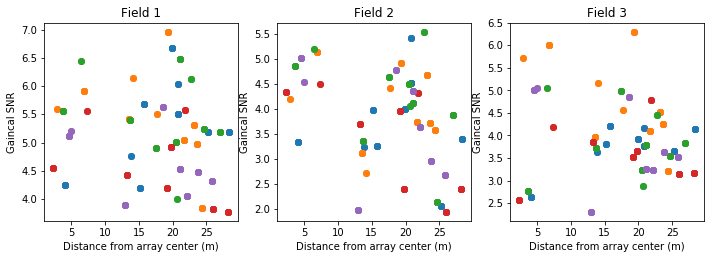

In [173]:
uoids = np.unique(data['OBSERVATION_ID'])
for ii,fldid in enumerate(fids):
    pl.subplot(2,4,ii+1)
    for oid in uoids:
        pl.plot([antdist[(ant,oid)] for ant,oo,fd in antstats if ((fd == fldid) and ((ant,oid,fldid) in antstats))],
                [antstats[(ant,oid,fldid)]['mean'] for ant,oo,fd in antstats  if ((fd == fldid) and ((ant,oid,fldid) in antstats))],
                'o')
    pl.xlabel("Distance from array center (m)")
    pl.ylabel("Gaincal SNR")
    pl.title(f"Field {fldid}")

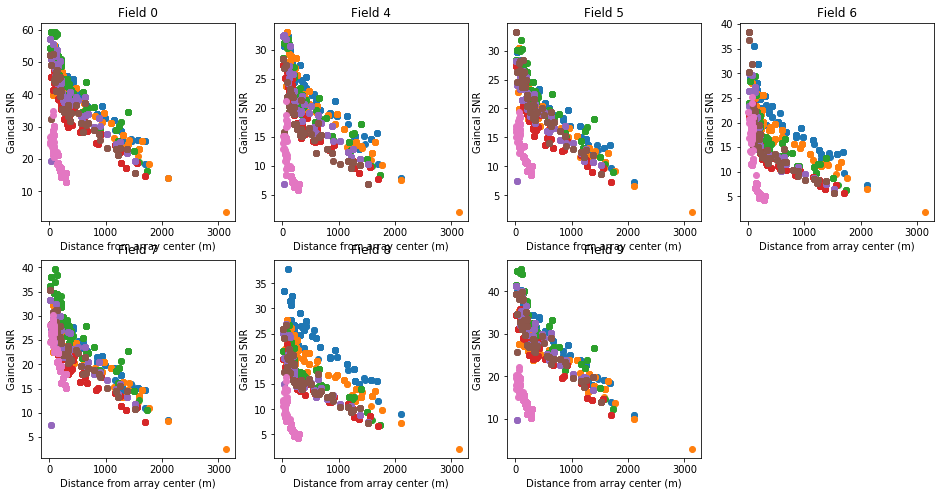

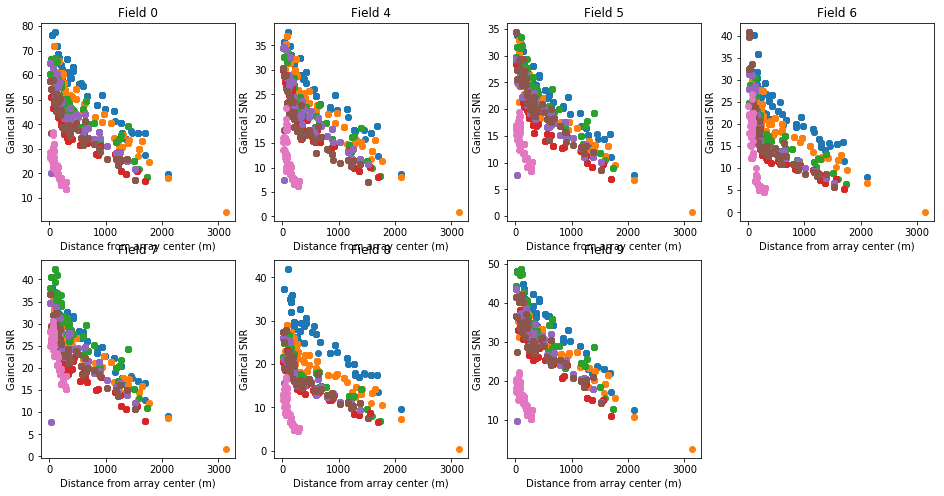

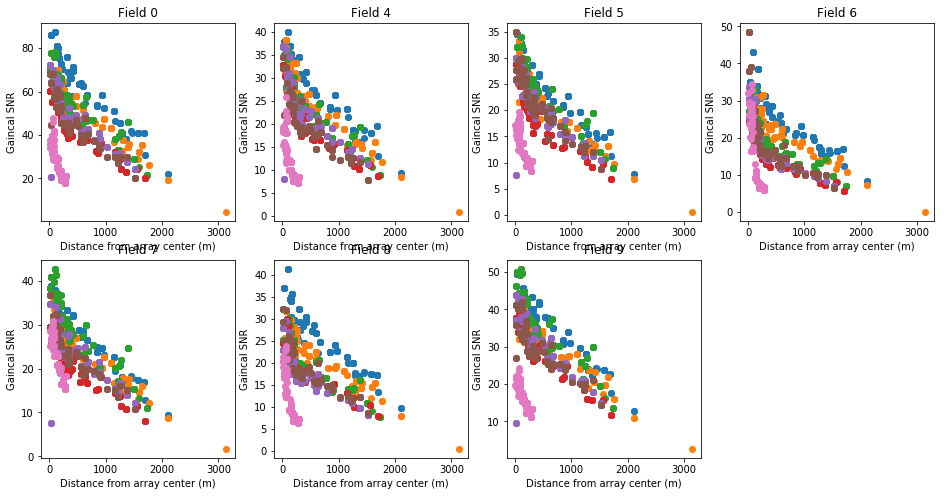

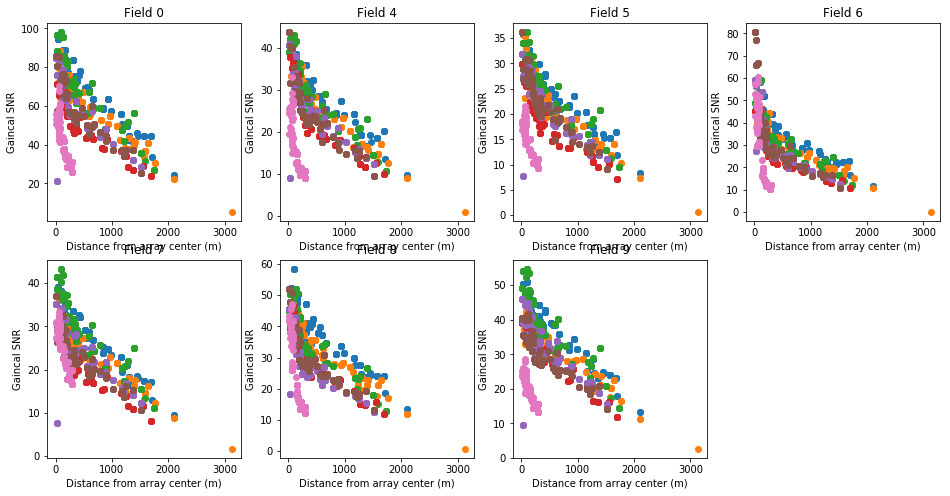

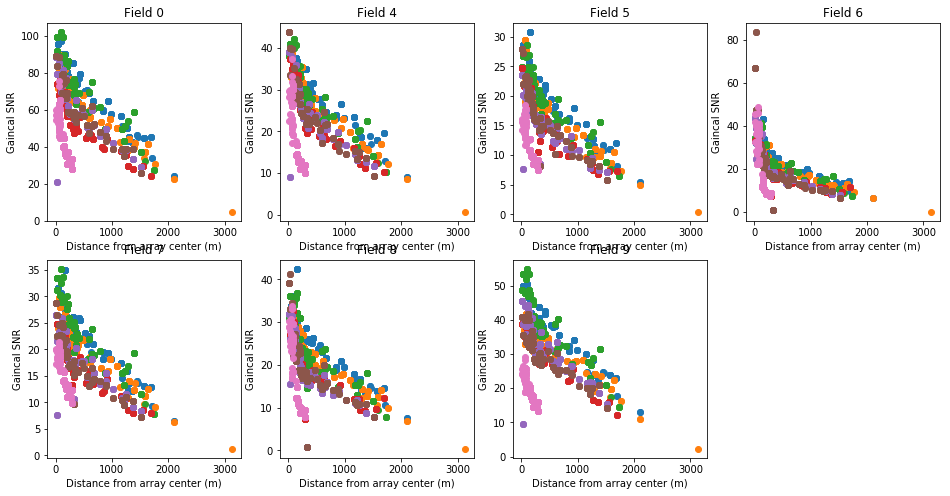

In [220]:
caltables = {}
for thisiter in (1,2,3,4,5):
    caltable = f'../W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_phase{thisiter}_int.cal/'

    tb.open(caltable)
    caltables[thisiter] = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
    caltables[thisiter]['ANGLE'] = np.angle(caltables[thisiter]['CPARAM']) * 180 / np.pi
    data = caltables[thisiter]

    spwids = np.unique(data['SPECTRAL_WINDOW_ID'])
    fids = np.unique(data['FIELD_ID'])
    data['ANGLE'] = np.angle(data['CPARAM']) * 180 / np.pi
    tb.close()

    antdist = {(ant,oid): antobs[oid]['antdist'][ant] for oid in antobs for ant in antobs[oid]['antnames']}
    antnames = {(ant,oid): antobs[oid]['antnames'][ant] for oid in antobs for ant in antobs[oid]['antnames']}

    antstats = {}
    for oid in np.unique(data['OBSERVATION_ID']):
        for antid in np.unique(data['ANTENNA1']):
            for field_id in fids:
                msk = (data['ANTENNA1'] == antid) & (OK[0,0,:]) & (data['FIELD_ID'] == field_id) & (data['OBSERVATION_ID'] == oid)
                if np.any(msk) and (antid, oid) in antnames:
                    dat = data['SNR'][1,0, msk]
                    ang = data['ANGLE'][1,0, msk]
                    #print(f"antenna={antnames[(antid,oid)]} oid={oid} dist={antdist[(antid,oid)]:6.1f} "
                    #      f"mean={dat.mean():10.2f} median={np.median(dat):10.2f} "
                    #      f"std={dat.std():10.2f}  angle_rms={ang.std()*180/np.pi:10.2f}")
                    antstats[(antid,oid,field_id)] = {'mean':dat.mean(),
                                       'median':np.median(dat),
                                       'std': dat.std(),
                                       'angle_rms': ang.std(),
                                                     }    
                    
    pl.figure()                    
    uoids = np.unique(data['OBSERVATION_ID'])
    for ii,fldid in enumerate(fids):
        pl.subplot(2,4,ii+1)
        for oid in uoids:
            pl.plot([antdist[(ant,oid)] for ant,oo,fd in antstats if ((fd == fldid) and ((ant,oid,fldid) in antstats))],
                    [antstats[(ant,oid,fldid)]['mean'] for ant,oo,fd in antstats  if ((fd == fldid) and ((ant,oid,fldid) in antstats))],
                    'o')
        pl.xlabel("Distance from array center (m)")
        pl.ylabel("Gaincal SNR")
        pl.title(f"Field {fldid}")
                    

fid = 0
nant = len(np.unique(data['ANTENNA1']))
for pol in (0,1):
    pl.figure()
    cnt = 0

    for ii,ant in enumerate(np.unique(data['ANTENNA1'])):
        ax = pl.subplot(4, 4, cnt+1)
        msk = (data['ANTENNA1'] == ant) & (data['FIELD_ID'] == fid) & (OK[pol,0,:]) & (data['SPECTRAL_WINDOW_ID'] == 12)
        ax.plot(data['ANGLE'][pol,0,msk])
        ax.set_title(str(ant))
        if np.any(msk):
            cnt += 1
        if cnt > 15:
            break


fid = 0
nant = len(np.unique(data['ANTENNA1']))
for oid in np.unique(data['OBSERVATION_ID']):
    for pol in (0,1):
        pl.figure()
        cnt = 0

        for ii,ant in enumerate(np.unique(data['ANTENNA1'])):
            ax = pl.subplot(4, 4, cnt+1)
            msk = (data['ANTENNA1'] == ant) & (data['FIELD_ID'] == fid) & (OK[pol,0,:]) & (data['OBSERVATION_ID'] == oid)
            spws = data['SPECTRAL_WINDOW_ID'][msk]
            
            
            if np.any(msk):
                cnt += 1
                for spw in np.unique(spws):
                    smsk = msk & (data['SPECTRAL_WINDOW_ID'] == spw)
                    time = data['TIME'][smsk] 
                    time -= np.min(time)
                    time /= 60
                    ang = data['ANGLE'][pol,0,smsk]
                    srt = np.argsort(time)
                    #ax.plot(time[srt], ang[srt], '.')
                    ax.plot(ang[srt], '-')
                ax.set_title(str(ant))
            if cnt > 15:
                break


In [219]:
ms.close()
msmd.close()

True